# Bayesian Sample Inference

This self-contained notebook contains a complete implementation of [BSI](https://arxiv.org/abs/2502.07580) for interactive exploration and understanding of the model. It will show you how to compute the training loss and train a small model on your machine. Then, we will compute the log-likelihood of an unseen data point in bits per dimension and generate new samples with our model.

The code in this notebook is minimal to focus on the core of the method. To use BSI in your own project, we recommend that you copy [bsi.py](./bsi/bsi.py) and use it as demonstrated in the [README](./README.md#getting-started).

We use [pytorch](https://pytorch.org) as the deep learning framework, [einops](https://einops.rocks) for natural shape manipulation of tensors, torchvision to load an example dataset, [jaxtyping](https://github.com/patrick-kidger/jaxtyping) to annotate the shapes of tensors, [tqdm](https://github.com/tqdm/tqdm) to indicate training progress, [numpy](https://numpy.org/) for math utilities and [matplotlib](https://matplotlib.org/) to visualize samples. You can install them into your current environment by running the following cell.

In [1]:
%pip install torch torchvision einops jaxtyping tqdm numpy matplotlib

In [2]:
import math
from dataclasses import dataclass

import einops as eo
import numpy as np
import torch
import torch.nn.functional as F
from einops.layers.torch import Rearrange
from jaxtyping import Float, Int
from matplotlib.pyplot import imshow
from torch import Tensor, nn
from torch.distributions import Normal
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

## Utilities

Normal tensor broadcasting in pytorch (and numpy) matches dimensions from right to left, broadcasting towards the left. However, the right-most dimensions are things like image coordinates and channels and we often want to, for example, multiply onto a batch of images where we have a coefficient for each image in a batch. The following extends a tensor as if we were broadcasting from the left towards the right to accomplish this.

In [3]:
def broadcast_right(x: Tensor, other: Tensor) -> Tensor:
    """Unsqueeze `x` to the right so that it broadcasts against `other`."""
    assert other.ndim >= x.ndim
    return x.reshape(*x.shape, *((1,) * (other.ndim - x.ndim)))

Furthermore, it will be useful to have a small class for a log-uniform distribution that quickly lets us access its CDF, inverse CDF and the (reciprocal of the) PDF. Getting the reciprocal is just very convenient for this distribution and since we end up dividing by the PDF anyway, this lets us exchange a division for a cheaper multiplication operation.

In [4]:
class LogUniform:
    def __init__(self, low: float, high: float):
        self.low = low
        self.high = high

        self.ln_low = math.log(self.low)
        self.ln_high = math.log(self.high)
        self.diff_ln_high_ln_low = self.ln_high - self.ln_low

    def reciprocal_pdf(self, value: Float[Tensor, "..."]) -> Float[Tensor, "..."]:
        """Return the reciprocal probability density at `value`."""
        return value * self.diff_ln_high_ln_low

    def cdf(self, value: Float[Tensor, "..."]) -> Float[Tensor, "..."]:
        return (torch.log(value) - self.ln_low) / self.diff_ln_high_ln_low

    def icdf(self, quantile: Float[Tensor, "..."]) -> Float[Tensor, "..."]:
        return torch.exp(self.diff_ln_high_ln_low * quantile + self.ln_low)

Finally, a small utility class to represent the discretization of discretized data that will be helpful when we compute the ELBO.

In [5]:
@dataclass
class Discretization:
    """A discretization of the interval [min, max] into k bins.

    The bins are open on the right and centered on `min + (max - min) * (i - 1) / (k -
    1)` for `i = 1..k`.
    """

    min: float
    max: float
    k: int

    @classmethod
    def image_8bit(cls):
        """Discretization of 8-bit images rescaled to the [-1, 1] interval."""
        return cls(-1.0, 1.0, 256)

    def bin_boundaries(self, device: torch.device, dtype: torch.dtype):
        dx = self.dx
        range_ = (self.min - dx / 2, self.max + dx / 2)
        return torch.linspace(*range_, self.k + 1, device=device, dtype=dtype)

    def bucketize(self, x: Float[Tensor, "..."]) -> Int[Tensor, "..."]:
        """Find the discrete bucket index of continuous values in the [min, max] range."""
        dx = self.dx
        return ((x - (self.min - dx / 2)) / dx).to(torch.int64).clamp(0, self.k - 1)

    @property
    def dx(self) -> float:
        """Width of a single bin."""
        return (self.max - self.min) / (self.k - 1)

## DiT backbone

We begin with implementing a [diffusion transformer](http://arxiv.org/abs/2212.09748) (DiT) as the underlying neural network, that learns to map our current belief $(\boldsymbol{\mu}, t)$ to an estimate of the underlying data sample $\hat{\boldsymbol{x}} = f_{\boldsymbol{\theta}}(\boldsymbol{\mu}, t)$. The details of the architecture are exchangeable and you could just as well use a U-Net here or something else that fits your data domain.

Feel free to [skip ahead to BSI model training](#Training), [ELBO computation](#Likelihoods) or [sampling](#Sampling). In this section, we will build up the DiT part by part.

### Attention

The first piece of code infrastructure is a 1D attention layer to attend to the image patches that the [Vision Transformer](https://arxiv.org/abs/2010.11929) underlying the DiT architecture splits the image into.

In [6]:
class Attention(nn.Module):
    def __init__(self, dim: int, *, heads: int, dropout: float = 0.0):
        super().__init__()

        self.heads = heads
        self.dropout = dropout

        self.to_qkv = nn.Linear(dim, dim * 3)
        self.to_out = nn.Linear(dim, dim)

    def forward(
        self, x: Float[Tensor, "batch patch feature"]
    ) -> Float[Tensor, "batch patch feature"]:
        q, k, v = eo.rearrange(
            self.to_qkv(x), "b p (qkv h c) -> qkv b h p c", qkv=3, h=self.heads
        ).contiguous()

        dropout_p = self.dropout if self.training else 0.0
        out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)

        out = eo.rearrange(out, "b h p c -> b p (h c)")
        return self.to_out(out)

### DiT block

With the attention module, we can build the DiT block with adaLN-Zero conditioning. They form the central components of a DiT and can be stacked to increase model capacity.

In [7]:
class DiTBlock(nn.Module):
    """A DiT block with adaptive layer norm zero (adaLN-Zero) conditioning."""

    def __init__(
        self, size: int, heads: int, mlp_ratio: int = 4, dropout: float | None = None
    ):
        super().__init__()

        self.norm = nn.LayerNorm(size, elementwise_affine=False)
        self.attn = Attention(
            size, heads=heads, dropout=dropout if dropout is not None else 0.0
        )
        self.dropout = nn.Dropout(dropout) if dropout is not None else nn.Identity()
        self.mlp = nn.Sequential(
            nn.Linear(size, mlp_ratio * size),
            nn.GELU(approximate="tanh"),
            nn.Linear(mlp_ratio * size, size),
        )
        # We add a linear layer in front of SiLU, so that not all layers just apply SiLU
        # to the exact same t embedding
        self.adaLN_modulation = nn.Sequential(
            nn.Linear(size, size), nn.SiLU(), nn.Linear(size, 6 * size)
        )

        # Initialize DiT block as identity (-Zero initialization)
        nn.init.constant_(self.adaLN_modulation[-1].weight, 0)
        nn.init.constant_(self.adaLN_modulation[-1].bias, 0)

    def forward(
        self, x: Float[Tensor, "batch patch feature"], c: Float[Tensor, "batch feature"]
    ) -> Float[Tensor, "batch patch feature"]:
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = (
            self.adaLN_modulation(c).chunk(6, dim=1)
        )
        x = torch.addcmul(
            x,
            gate_msa.unsqueeze(dim=1),
            self.attn(self.modulate(self.norm(x), shift_msa, scale_msa)),
        )
        x = torch.addcmul(
            x,
            gate_mlp.unsqueeze(dim=1),
            self.mlp(self.dropout(self.modulate(self.norm(x), shift_mlp, scale_mlp))),
        )
        return x

    def modulate(
        self,
        x: Float[Tensor, "batch patch feature"],
        shift: Float[Tensor, "batch feature"],
        scale: Float[Tensor, "batch feature"],
    ) -> Float[Tensor, "batch patch feature"]:
        """Feature modulation."""
        return torch.addcmul(shift[:, None], scale[:, None] + 1, x)

### Positional Embeddings

The DiT uses positional embeddings in two ways: first, to encode the position of each patch in the 2D image grid and, second, to encode the noise level $t$.

Our positional embedding is a sinusoidal one as in [Attention is all you need](https://arxiv.org/abs/1706.03762). We base our choice of minimum and maximum frequency on an approximation and a signal processing argument, respectively, instead of the original, seemingly ad hoc, choices of 1 and $10^{-4}$, but in practice, these seem to make no difference.

In [8]:
class NyquistPositionalEmbedding(nn.Module):
    """Sine-cosine embedding for position `t` in `[0, 1]` that scales from a frequency
    of 1/8 to a (< 1) multiple of the Nyquist frequency.

    In the original sinusoidal embedding from "Attention is all you need" [1], the high
    frequencies are so high that the corresponding embedding features are basically
    random and the inner product between two embeddings `e(t_0)` and `e(t_1)` becomes
    noisy instead of varying smoothly as `t_0 - t_1` grows. At the same time, the
    slowest frequency is still so high that no feature just varies linearly with `t`,
    which we believe to be important.

    We choose 1/8 as the slowest frequency so that the slowest-varying embedding varies
    roughly lineary across [0, 2pi] as the relative error between x and sin(x) on [0,
    2pi / 8] is at most 2.5%. For the highest frequency, we pick a value dependent on
    the Nyquist frequency of the expected sampling rate of the embedding.

    The Nyquist frequency is the largest frequency that one can sample at a given rate
    without aliasing, so one could assume that to be a great choice for the highest
    frequency but sampling sine and cosine at the Nyquist frequency would result in
    constant (and therefore uninformative) 1 and 0 features.

    Instead, we choose the maximum frequency as Nyquist/(2*phi) where phi is the golden
    ratio. The exact choice is arbitrary as long as it is some irrational number
    somewhat smaller than the Nyquist frequency. The irrationality ensures that the
    high-frequency features do not oscillate between a fixed number of values, e.g. at
    Nyquist/2, the fastest-varying feature would just take the values -1, 0 and 1 when
    sampled at the given expected rate.

    [1] https://arxiv.org/abs/1706.03762
    """

    def __init__(self, size: int, expected_rate: int):
        """Construct the embedding.

        Args:
            size: Embedding dimensions.
            expected_rate: Expected sampling rate to compute the Nyquist frequency and
              thus the frequencies for the embeddings. A value of `10` means that you
              expect embeddings to be computed for 1/10, 2/10, ..., 1.
        """

        super().__init__()

        self.size = size

        assert size % 2 == 0

        k = size // 2

        # Nyquist frequency for a given sampling rate per unit interval
        nyquist_frequency = expected_rate / 2

        golden_ratio = (1 + np.sqrt(5)) / 2
        frequencies = np.geomspace(1 / 8, nyquist_frequency / (2 * golden_ratio), num=k)

        # Sample every frequency twice, once shifted by pi/2 to get cosine
        scale = np.repeat(2 * np.pi * frequencies, 2)
        bias = np.tile(np.array([0, np.pi / 2]), k)

        self.register_buffer(
            "scale", torch.tensor(scale, dtype=torch.float32), persistent=False
        )
        self.register_buffer(
            "bias", torch.tensor(bias, dtype=torch.float32), persistent=False
        )

    def forward(self, t: Float[Tensor, "..."]) -> Float[Tensor, "... size"]:
        """Embed the timestep t into a sine-cosine representation.

        Args:
            t: Batch of timesteps between 0 and 1.
        """

        return torch.addcmul(self.bias, self.scale, t[..., None]).sin()

### DiT

Now, we combine the pieces into a DiT.

In [9]:
class DiT(nn.Module):
    """Diffusion model with a Transformer backbone [1].

    [1] https://arxiv.org/abs/2212.09748
    """

    def __init__(
        self,
        input_size: tuple[int, int],
        patch_size: int,
        in_channels: int,
        out_channels: int,
        hidden_size: int,
        depth: int,
        heads: int,
        mlp_ratio: int,
        dropout: float | None,
    ):
        super().__init__()

        self.input_size = input_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.out_channels = out_channels

        height, width = input_size
        patch_area = patch_size**2
        patches_h = height // patch_size
        patches_w = width // patch_size

        # Use fixed Fourier positional embeddings
        pos_embedding = NyquistPositionalEmbedding(hidden_size // 2, max(height, width))
        pos_h = pos_embedding(torch.linspace(0, 1, patches_h))
        pos_w = pos_embedding(torch.linspace(0, 1, patches_w))
        pos_embs = torch.cat(
            (
                eo.repeat(pos_h, "ph c -> (ph pw) c", pw=patches_w),
                eo.repeat(pos_w, "pw c -> (ph pw) c", ph=patches_h),
            ),
            dim=1,
        )
        self.register_buffer("patch_pos_embedding", pos_embs, persistent=False)
        self.t_embedding = NyquistPositionalEmbedding(hidden_size, 1000)

        self.patchify = Rearrange(
            "batch c (nh ps_h) (nw ps_w) -> batch (nh nw) (ps_h ps_w c)",
            ps_h=patch_size,
            ps_w=patch_size,
        )
        self.patch_encoder = nn.Linear(patch_area * in_channels, hidden_size)

        self.blocks = nn.ModuleList(
            [
                DiTBlock(hidden_size, heads, mlp_ratio=mlp_ratio, dropout=dropout)
                for _ in range(depth)
            ]
        )

        self.patch_decoder = nn.Sequential(
            nn.LayerNorm(hidden_size), nn.Linear(hidden_size, patch_area * out_channels)
        )
        self.unpatchify = Rearrange(
            "batch (nh nw) (ps_h ps_w c) -> batch c (nh ps_h) (nw ps_w)",
            nh=height // patch_size,
            nw=width // patch_size,
            ps_h=patch_size,
            ps_w=patch_size,
        )

    def forward(
        self, x: Float[Tensor, "batch channel height width"], t: Float[Tensor, "batch"]
    ) -> Float[Tensor, "batch channel height width"]:
        c = self.t_embedding(t)
        x = self.patch_encoder(self.patchify(x)) + self.patch_pos_embedding
        for block in self.blocks:
            x = block(x, c)
        return self.unpatchify(self.patch_decoder(x))

### Fourier Features

Next, we have a module that computes Fourier features as proposed in [Variational Diffusion Models](https://arxiv.org/abs/2006.10739). In the end, these are sinusoidal embeddings for each input feature that help the neural network distinguish small variations of features at very low noise levels and are essential to achieve high likelihoods.

In [10]:
class FourierFeatures(nn.Module):
    """Compute Fourier features as proposed in the VDM paper [1].

    [1] https://arxiv.org/abs/2006.10739
    """

    def __init__(self, *, n_min: int, n_max: int):
        super().__init__()

        self.n_min = n_min
        self.n_max = n_max

        ns = torch.arange(n_min, n_max + 1)
        self.register_buffer("coefs", 2 * torch.pi * 2**ns, persistent=False)
        self.register_buffer("offsets", torch.tensor([0, torch.pi / 2]), persistent=False)

    def n_features(self):
        return len(self.coefs) * len(self.offsets)

    def forward(self, x: Tensor, *, dim: int) -> Tensor:
        assert dim >= 0, "Implementation expects a non-negative dimension index"

        # Multiply each feature with each frequency and add each offset by expanding the
        # channel dimension twice and then aligning the cofficient and offset tensors
        # with them.
        right_dims = x.dim() - dim - 1
        x = x.unsqueeze(dim + 1).unsqueeze(dim + 1)
        coefs = self.coefs.view((-1, *([1] * (right_dims + 1))))
        offsets = self.offsets.view((-1, *([1] * right_dims)))
        args = torch.addcmul(offsets, coefs, x)

        return args.sin().flatten(start_dim=dim, end_dim=dim + 2)

### Denoising Model

Our final denoising model $f_{\boldsymbol{\theta}}$ computes Fourier features for $\boldsymbol{\mu}$ and passes the result into a DiT.

In [11]:
class DenoisingDiT(nn.Module):
    """Diffusion Transformer."""

    def __init__(
        self,
        *,
        data_shape: tuple[int, ...],
        patch_size: int,
        dim: int,
        depth: int,
        heads: int,
        dropout: float | None = None,
    ):
        super().__init__()

        self.data_shape = tuple(data_shape)
        self.fourier_features = FourierFeatures(n_min=6, n_max=8)

        assert len(self.data_shape) == 3, "Only works for 2D images"

        n_channels = data_shape[0]
        in_channels = n_channels * (1 + self.fourier_features.n_features())
        out_channels = n_channels

        self.dit = DiT(
            input_size=data_shape[1:],
            patch_size=patch_size,
            in_channels=in_channels,
            out_channels=out_channels,
            hidden_size=dim,
            depth=depth,
            heads=heads,
            mlp_ratio=4,
            dropout=dropout,
        )

    def forward(
        self, mu: Float[Tensor, "batch data_shape"], t: Float[Tensor, "batch"]
    ) -> Float[Tensor, "batch data_shape"]:
        return self.dit(torch.cat([mu, self.fourier_features(mu, dim=1)], dim=1), t)

### Preconditioning

As the last piece, we add a preconditioning wrapper that
1. converts the $\lambda$ argument into a $t \in [0, 1]$ via the inverse CDF of $p(\lambda)$ to transform it into a better feature for a neural network and
2. applies the preconditioning skip connection described in Section 5.1 of [the paper](https://arxiv.org/pdf/2502.07580).

In [12]:
class Preconditioning(nn.Module):
    def __init__(self, model: DenoisingDiT, p_lambda: LogUniform):
        super().__init__()

        self.model = model
        self.p_lambda = p_lambda

    def forward(
        self, mu: Float[Tensor, "batch data_shape"], lambda_: Float[Tensor, "batch"]
    )  -> Float[Tensor, "batch data_shape"]:
        # Preconditioning parameters
        lambda_0 = self.p_lambda.low
        alpha = lambda_ - lambda_0
        # Written in this way to avoid squaring alpha for float stability
        kappa = 1 + alpha * (alpha / lambda_)
        c_skip = alpha / kappa
        c_out = torch.rsqrt(kappa)
        c_in = torch.sqrt(lambda_ / kappa)

        t = self.p_lambda.cdf(lambda_)
        return broadcast_right(c_skip, mu) * mu + broadcast_right(c_out, mu) * self.model(broadcast_right(c_in, mu) * mu, t)

# Training

To train the model, we implement Algorithm 2 from the paper.

![](figures/algorithm-loss.webp)

In [13]:
def bsi_train_loss(
    model: nn.Module,
    p_lambda: LogUniform,
    x: Float[Tensor, "batch channels height width"],
    generator: torch.Generator | None = None
) -> Float[Tensor, "batch"]:
    batch_size = x.shape[0]
    t = torch.rand(batch_size, dtype=x.dtype, device=x.device, generator=generator)
    epsilon = torch.randn(x.shape, dtype=x.dtype, device=x.device, generator=generator)
    lambda_ = p_lambda.icdf(t)
    lambda_0 = p_lambda.low
    mu_lambda = broadcast_right((lambda_ - lambda_0) / lambda_, x) * x + broadcast_right(torch.rsqrt(lambda_), epsilon) * epsilon
    # This is the same as the infinite step measurement loss L_M^infty in the paper but we take the mean here to
    # make the magnitude of the loss independent of the data dimension and save us the multiplication by 1/2.
    return p_lambda.diff_ln_high_ln_low * lambda_ * eo.reduce((x - model(mu_lambda, lambda_))**2, "batch ... -> batch", "mean")

Now we choose the BSI hyperparameters $\lambda_0$, $\alpha_M$ and instantiate the model. Note that the CPU and GPU model configurations in the cells below are optimized for quick, interactive exploration and fast training. To achieve excellent likelihoods and high sample quality, please refer to the settings described in the paper and the experiments configurations in the [paper repository](https://github.com/martenlienen/bis).

The configuration below trains for about half hour on a GTX1080.

In [14]:
lambda_0 = 1e-2
alpha_M = 1e6
alpha_R = 2 * alpha_M

batch_size = 128
n_epochs = 50
seed = 851

if torch.cuda.is_available():
    # A small GPU configuration
    model_params = {"dim": 128, "depth": 12, "patch_size": 4, "heads": 1}
    device = torch.device("cuda")

    # The configuration used in the paper for CIFAR10
    #model_params = {"dim": 128, "depth": 32, "patch_size": 2, "heads": 1}
else:
    # A tiny CPU configuration
    model_params = {"dim": 128, "depth": 4, "patch_size": 4, "heads": 1}
    device = torch.device("cpu")

From the hyperparameters, we create the importance sampling distribution and instantiate the model.

In [15]:
lambda_M = lambda_0 + alpha_M
p_lambda = LogUniform(lambda_0, lambda_M)

inner_model = DenoisingDiT(data_shape=(3, 32, 32), dropout=0.1, **model_params)
model = Preconditioning(inner_model, p_lambda)
model.to(device);

It remains to load the training data, configure the optimizer and fix a generator for reproducible training noise.

In [16]:
transforms = v2.Compose(
    [v2.ToImage(), v2.ToDtype(dtype=torch.float32, scale=True), v2.Normalize(mean=[0.5], std=[0.5])])
train_data = CIFAR10("./data/cifar10/", train=True, download=True, transform=transforms)

shuffle_generator = torch.Generator().manual_seed(seed)
loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=shuffle_generator)
opt = torch.optim.AdamW(model.parameters(), lr=2e-4)
generator = torch.Generator(device).manual_seed(seed)

The following cell is just a simple training loop.

In [17]:
losses = []
model.train()
for epoch in range(n_epochs):
    bar = tqdm(loader, desc=f"Epoch {epoch + 1}", leave=epoch == n_epochs - 1)
    for i, (x, _) in enumerate(bar):
        loss = bsi_train_loss(model, p_lambda, x.to(device), generator).mean()
    
        opt.zero_grad()
        loss.backward()
        opt.step()
    
        losses.append(loss.item())
        bar.set_postfix(loss=np.mean(losses[-100:]))

Epoch 50:   0%|          | 0/391 [00:00<?, ?it/s]

## Likelihoods

With the trained model, we can now estimate a lower bound (ELBO) on the likelihood $p(x)$ in bits per dimension that the trained model assigns to a data sample $x$.

The most complex part of this is to compute the reconstruction loss correctly where we need to work with a discretized Gaussian likelihood.

In [18]:
def bsi_reconstruction_loss(
    model: nn.Module,
    p_lambda: LogUniform,
    alpha_R: float,
    x: Float[Tensor, "batch channels height width"],
    generator: torch.Generator | None = None
) -> Float[Tensor, "batch"]:
    """Estimate the reconstruction loss L_R."""

    lambda_0 = p_lambda.low
    lambda_M = p_lambda.high
    mu_lambda_M = (
        ((lambda_M - lambda_0) / lambda_M) * x +
        x / math.sqrt(lambda_M) *
        torch.randn(x.shape, device=x.device, dtype=x.dtype, generator=generator)
    )
    x_hat = model(mu_lambda_M, x.new_full((x.shape[0],), lambda_M))

    p_recon = Normal(
        x_hat, torch.full_like(x_hat, 1 / math.sqrt(alpha_R)), validate_args=False
    )
    discretization = Discretization.image_8bit()
    boundaries = discretization.bin_boundaries(x.device, x.dtype)
    x_idx = discretization.bucketize(x)
    cdf_left = p_recon.cdf(boundaries[x_idx])
    cdf_right = p_recon.cdf(boundaries[x_idx + 1])
    cdf_left_clamped = torch.where(x_idx == 0, 0, cdf_left)
    cdf_right_clamped = torch.where(x_idx == discretization.k - 1, 1, cdf_right)
    log_p_per_dim = torch.log(
        torch.clamp(cdf_right_clamped - cdf_left_clamped, min=1e-20)
    )

    return eo.reduce(-log_p_per_dim, "batch ... -> batch", "sum")

The measurement loss is basically the same as the train loss except that we take the sum instead of the mean over data dimensions and multiply by 1/2.

In [19]:
def bsi_measurement_loss(
    model: nn.Module,
    p_lambda: LogUniform,
    x: Float[Tensor, "batch channels height width"],
    generator: torch.Generator | None = None
) -> Float[Tensor, "batch"]:
    batch_size = x.shape[0]
    t = torch.rand(batch_size, dtype=x.dtype, device=x.device, generator=generator)
    epsilon = torch.randn(x.shape, dtype=x.dtype, device=x.device, generator=generator)
    lambda_ = p_lambda.icdf(t)
    lambda_0 = p_lambda.low
    mu_lambda = broadcast_right((lambda_ - lambda_0) / lambda_, x) * x + broadcast_right(torch.rsqrt(lambda_), epsilon) * epsilon
    return 0.5 * p_lambda.reciprocal_pdf(lambda_) * eo.reduce((x - model(mu_lambda, lambda_))**2, "batch ... -> batch", "sum")

In [20]:
def bsi_likelihood_bpd(
    model: nn.Module,
    p_lambda: LogUniform,
    alpha_R: float,
    x: Float[Tensor, "batch channels height width"],
    generator: torch.Generator | None = None
) -> Float[Tensor, "batch"]:
    """Estimate the ELBO in bits per dimension."""

    l_measure = bsi_measurement_loss(model, p_lambda, x, generator)
    l_recon = bsi_reconstruction_loss(model, p_lambda, alpha_R, x, generator)
    # ELBO is just the negative sum of the two components
    elbo = -(l_recon + l_measure)

    # Convert to bits per dimension
    n_dim = math.prod(x.shape[1:])
    bpd = (-1 / (math.log(2) * n_dim)) * elbo

    return bpd

Now, we can estimate the ELBO over the test set.

In [21]:
test_data = CIFAR10("./data/cifar10/", train=False, download=True, transform=transforms)

In [22]:
bpds = []
generator = torch.Generator(device).manual_seed(seed)
with torch.inference_mode():
    model.eval()
    loader = DataLoader(test_data, batch_size=batch_size)
    bar = tqdm(loader, desc="Evaluate bpd", leave=False)
    for x, _ in bar:
        bpd = bsi_likelihood_bpd(model, p_lambda, alpha_R, x.to(device), generator)
        bpds.append(bpd)
        bar.set_postfix(bpd=bpd.mean().item())
bpds = torch.cat(bpds)

print(f"Average ELBO in bpd on the test set: {bpds.mean():.2f}")

Evaluate bpd:   0%|          | 0/79 [00:00<?, ?it/s]

Average ELBO in bpd on the test set: 4.23


## Sampling

Sampling with a trained BSI model just needs the following algorithm:

![](figures/algorithm-sampling.webp)

In [23]:
def bsi_sample(
    model: nn.Module,
    p_lambda: LogUniform,
    batch_size: int,
    k: int,
    generator: torch.Generator | None = None
) -> Float[Tensor, "batch channel height width"]:
    lambda_0 = torch.tensor(p_lambda.low, device=device)
    alphas = p_lambda.icdf(torch.linspace(0, 1, k + 1, device=device)).diff()
    epsilon_0, *epsilons = torch.randn((k + 1, batch_size, *model.model.data_shape), device=device)
    mu = torch.rsqrt(lambda_0) * epsilon_0
    lambda_ = eo.repeat(lambda_0, "-> b", b=batch_size)
    for alpha, epsilon in zip(alphas, epsilons):
        x_hat = model(mu, lambda_)
        lambda_next = lambda_ + alpha
        mu = (broadcast_right(lambda_, mu) * mu + alpha * (x_hat + torch.rsqrt(alpha) * epsilon)) / broadcast_right(lambda_next, mu)
        lambda_ = lambda_next
    return model(mu, lambda_)

Let's generate a few samples and visualize them.

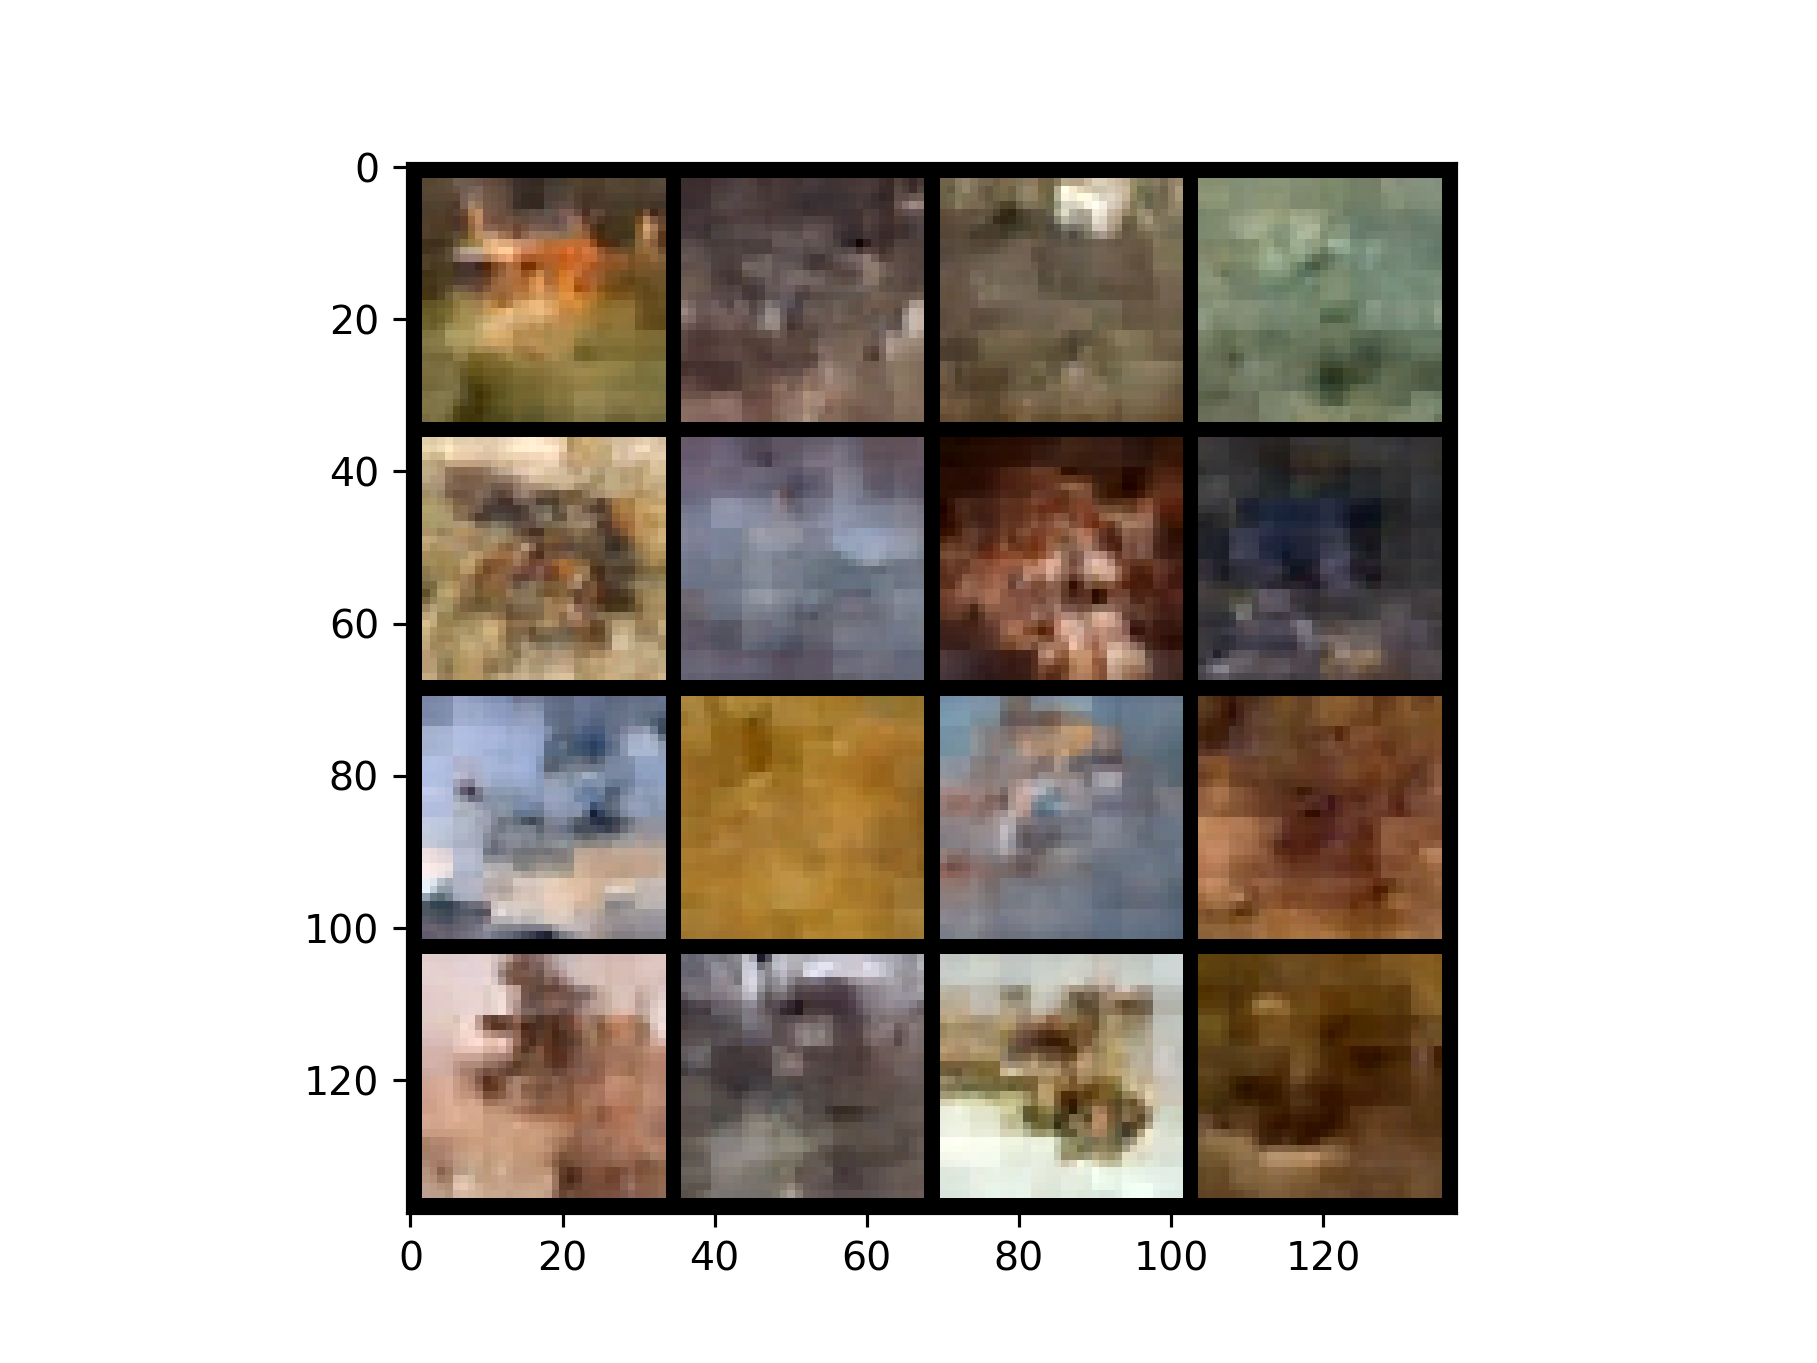

In [24]:
generator = torch.Generator(device).manual_seed(seed)
with torch.inference_mode():
    model.eval()
    samples = bsi_sample(model, p_lambda, batch_size=16, k=100, generator=generator)

img_grid = make_grid(samples.cpu(), nrow=4, normalize=True, value_range=(-1, 1))
imshow(torch.movedim(img_grid, 0, -1))